# CSC6711 Project 3 - Non-Personalized Recommendations

* **Author**: Jacob Buysse

This notebook is an analysis of the non-personalized predictions from the 4 datasets from Project 2 and how good they are at predicing the individual users actual ratings.  The files are located in the `datasets` subdirectory:
* MovieLens - `movielens_25m.feather` (Movies)
* Netflix Prize - `netflix_prize.feather` (Movies and TV Shows)
* Yahoo! Music R2 - `yahoo_r2_songs.subsampled.feather` (Songs)
* BoardGameGeek - `boardgamegeek.feather` (Board Games)

We will be using the following libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import linregress

Let us configure matplotlib for readable labels, high resolution, and automatic layout.

In [2]:
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('figure', dpi=150, autolayout=True)

## Datasets

Let us load the databases using Pandas.  We know from Project 2 that the contents are structured identically:

* `df1` - MovieLens
* `df2` - Netflix
* `df3` - Yahoo Music
* `df4` - BoardGameGeek

In each file, we have `item_id`, `user_id`, and `rating`.

In [3]:
df1 = pd.read_feather('./datasets/movielens_25m.feather')
df2 = pd.read_feather('./datasets/netflix_prize.feather')
df3 = pd.read_feather('./datasets/yahoo_r2_songs.subsampled.feather')
df4 = pd.read_feather('./datasets/boardgamegeek.feather')

We need to tweak the data for BoardGameGeek.  It has user_id as a string and we will encode it to a numeric using `LabelEncoder`.

In [4]:
user_id4_encoder = LabelEncoder()
user_id4_encoder.fit(df4.user_id);
df4['user_id'] = user_id4_encoder.transform(df4.user_id)
df4['rating_bin'] = np.floor(df4.rating)

Next, let us split the datasets into 75/25 train/test subsets.  We will define a helper function `TrainTestSplit` to do that.

In [5]:
def TrainTestSplit(df):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=777)
    train_index, test_index = next(gss.split(X=df, y=df.rating, groups=df.user_id))
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    total_count = train_df.shape[0] + test_df.shape[0];
    item_count = df.item_id.nunique()
    user_count = df.user_id.nunique()
    train_pct_total = train_df.shape[0] / total_count
    test_pct_total = test_df.shape[0] / total_count
    train_pct_item = train_df.item_id.nunique() / item_count
    test_pct_item = test_df.item_id.nunique() / item_count
    train_pct_user = train_df.user_id.nunique() / user_count
    test_pct_user = test_df.user_id.nunique() / user_count
    print(f"Train {train_df.shape} ({train_pct_total:.0%} total, {train_pct_item:.0%} items, {train_pct_user:.0%} users) " +
          f"Test {test_df.shape} ({test_pct_total:.0%} total, {test_pct_item:.0%} items, {test_pct_user:.0%} users)")
    print(f"Distinct Testing Users: {test_df.user_id.nunique()}")
    return train_df, test_df

train_df1, test_df1 = TrainTestSplit(df1)
train_df2, test_df2 = TrainTestSplit(df2)
train_df3, test_df3 = TrainTestSplit(df3)
train_df4, test_df4 = TrainTestSplit(df4)

Train (18706943, 3) (75% total, 100% items, 75% users) Test (6183640, 3) (25% total, 99% items, 25% users)
Distinct Testing Users: 40636
Train (38278492, 3) (75% total, 100% items, 75% users) Test (12752863, 3) (25% total, 100% items, 25% users)
Distinct Testing Users: 119505
Train (5201846, 3) (75% total, 100% items, 75% users) Test (1735429, 3) (25% total, 100% items, 25% users)
Distinct Testing Users: 313816
Train (14159851, 4) (75% total, 100% items, 75% users) Test (4782364, 4) (25% total, 100% items, 25% users)
Distinct Testing Users: 102844


We can see we have a 75/25 split for total record count and additionally by users (the grouping provided by the `GroupShuffleSplit` helper).   We can also see that all items are accounted for in every training set and all but one testing set - with the remaining one still containing 99% of items.

## Generating Recommendations

We will now compute the average rating, awareness (number of ratings), and popularity (number of positive ratings) for each item in the training sets.

In [6]:
def GenerateItemRatings(df, min_positive_rating):
    result = df.groupby(['item_id']).agg(
        avg_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
        rating_count=pd.NamedAgg(column='rating', aggfunc='count'),
        positive_count=pd.NamedAgg(column='rating', aggfunc=lambda rating: (rating >= min_positive_rating).sum())
    ).reset_index()
    display(result)
    return result

ratings1 = GenerateItemRatings(train_df1, 4)
ratings2 = GenerateItemRatings(train_df2, 4)
ratings3 = GenerateItemRatings(train_df3, 4)
ratings4 = GenerateItemRatings(train_df4, 7)

,item_id,avg_rating,rating_count,positive_count
0,1,3.891987,42990,28188
1,2,3.253280,18219,6203
2,3,3.143212,8854,2767
3,4,2.843684,1900,467
4,5,3.056762,8844,2391
...,...,...,...,...
24325,207405,3.695652,23,11
24326,207612,3.687500,8,3
24327,207830,3.500000,41,13
24328,208715,2.750000,10,2


,item_id,avg_rating,rating_count,positive_count
0,1,3.722078,385,242
1,2,3.580952,105,59
2,3,3.655695,1519,940
3,4,2.647619,105,27
4,5,3.904762,861,624
...,...,...,...,...
9205,9206,3.750682,1833,1170
9206,9207,3.144414,1101,392
9207,9208,3.917260,14334,10300
9208,9209,2.660000,100,27


,item_id,avg_rating,rating_count,positive_count
0,118,3.260179,4028,1976
1,209,2.410853,1419,401
2,598,3.303069,3161,1590
3,771,3.153403,867,385
4,904,2.931818,1452,638
...,...,...,...,...
1363,136288,3.113446,40504,18611
1364,136350,3.634051,1533,942
1365,136404,2.788927,1156,448
1366,136590,2.871777,1474,581


,item_id,avg_rating,rating_count,positive_count
0,1,7.658831,3999,3213
1,2,6.649546,415,222
2,3,7.486683,11303,9271
3,4,6.588841,267,135
4,5,7.435946,13835,10807
...,...,...,...,...
21920,347146,7.335294,34,25
21921,347521,7.830702,57,54
21922,348955,7.068182,44,30
21923,349131,6.513462,52,29


Now we need to join our item rating data to our testing data to come up with a prediction vs. actual rating dataset we can then score.

In [7]:
def ScoreRatings(df, ratings, agg_column):
    pred = df.merge(ratings, on='item_id')
    result = linregress(pred.rating, pred[agg_column])
    rvalue = result.rvalue
    coef_det = rvalue * rvalue
    print(f"R^2 = {coef_det:.0%}")

for agg_column in ['avg_rating', 'rating_count', 'positive_count']:
    print(f"Correlation between true rating and {agg_column}:")
    ScoreRatings(test_df1, ratings1, agg_column)
    ScoreRatings(test_df2, ratings2, agg_column)
    ScoreRatings(test_df3, ratings3, agg_column)
    ScoreRatings(test_df4, ratings4, agg_column)

Correlation between true rating and avg_rating:
R^2 = 18%
R^2 = 13%
R^2 = 11%
R^2 = 26%
Correlation between true rating and rating_count:
R^2 = 4%
R^2 = 1%
R^2 = 0%
R^2 = 4%
Correlation between true rating and positive_count:
R^2 = 6%
R^2 = 3%
R^2 = 1%
R^2 = 5%


Now let us compare the true values of our test dataset against each of the three possible aggregate predictors using boxplots.

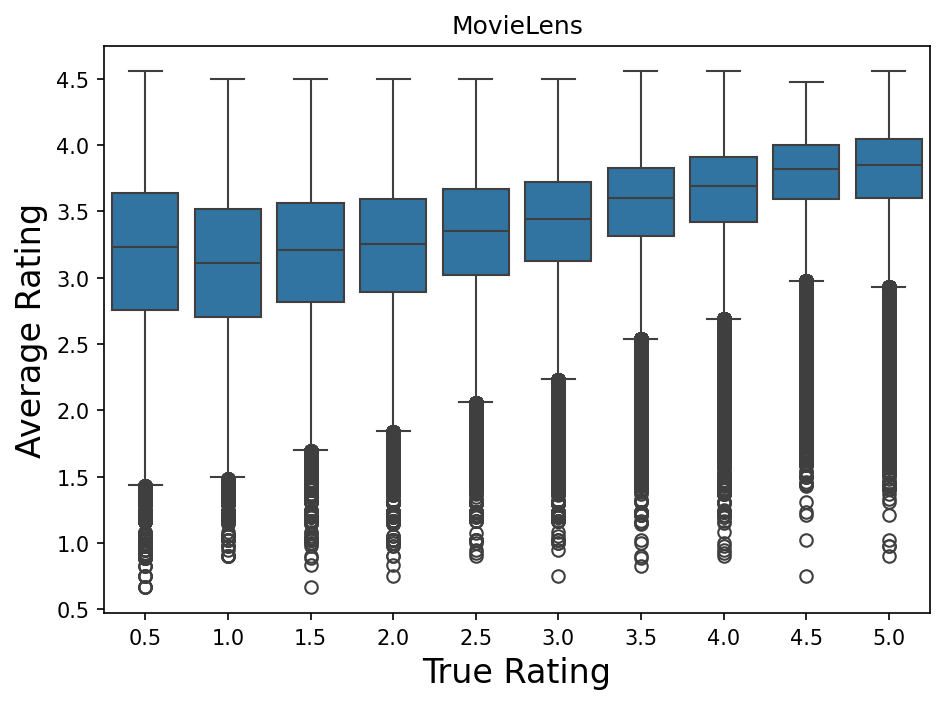

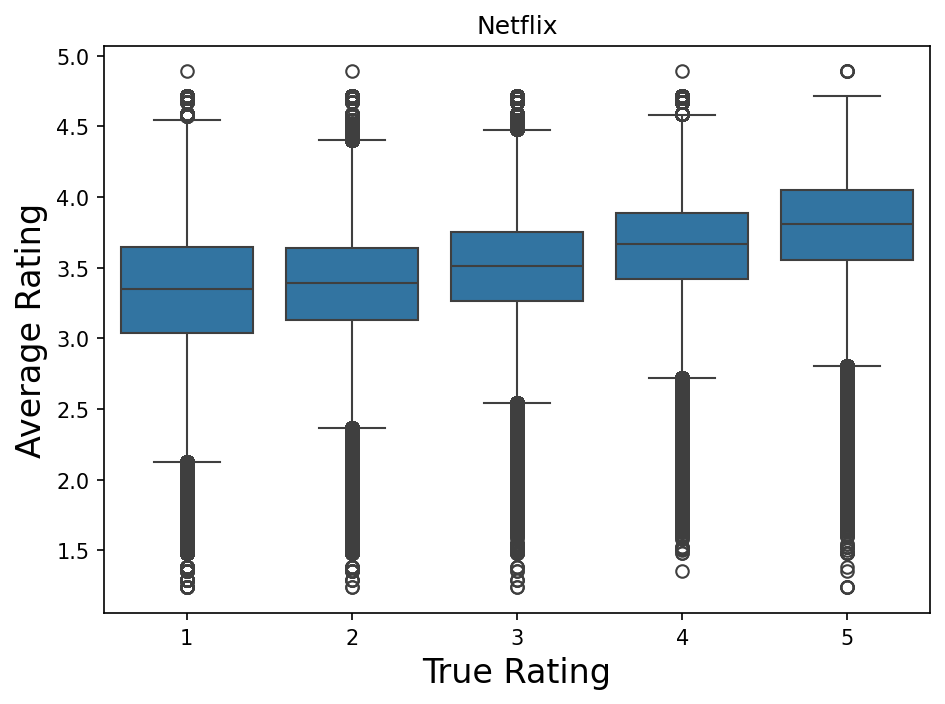

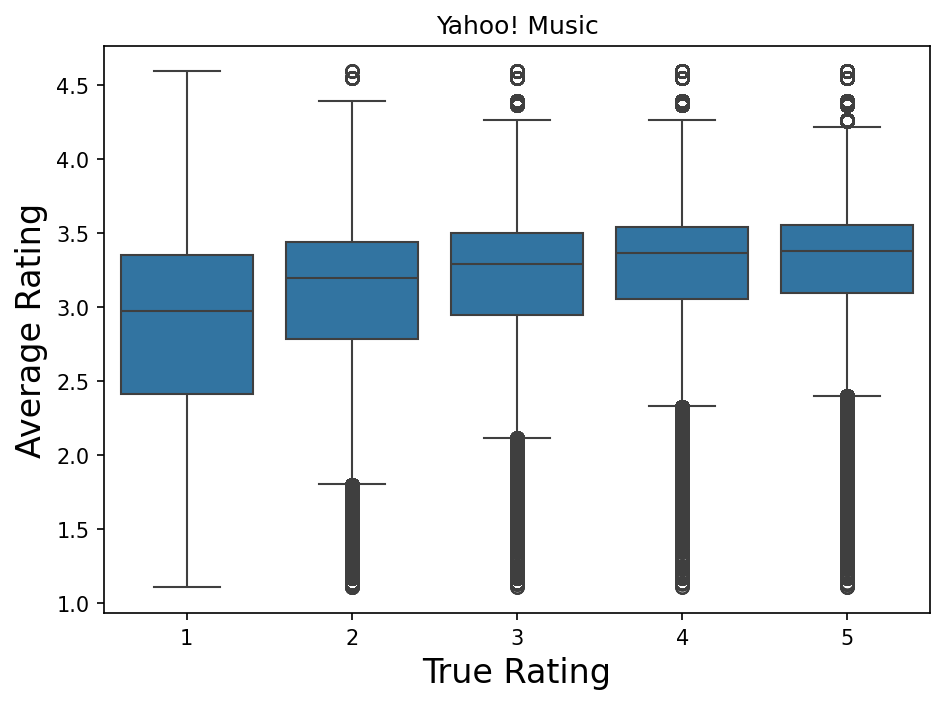

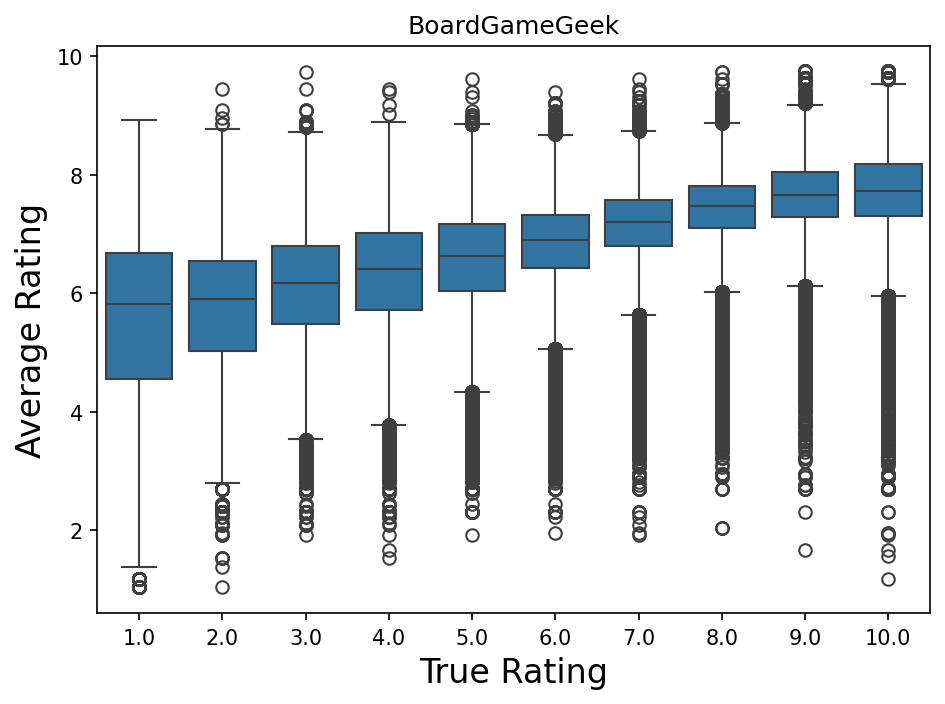

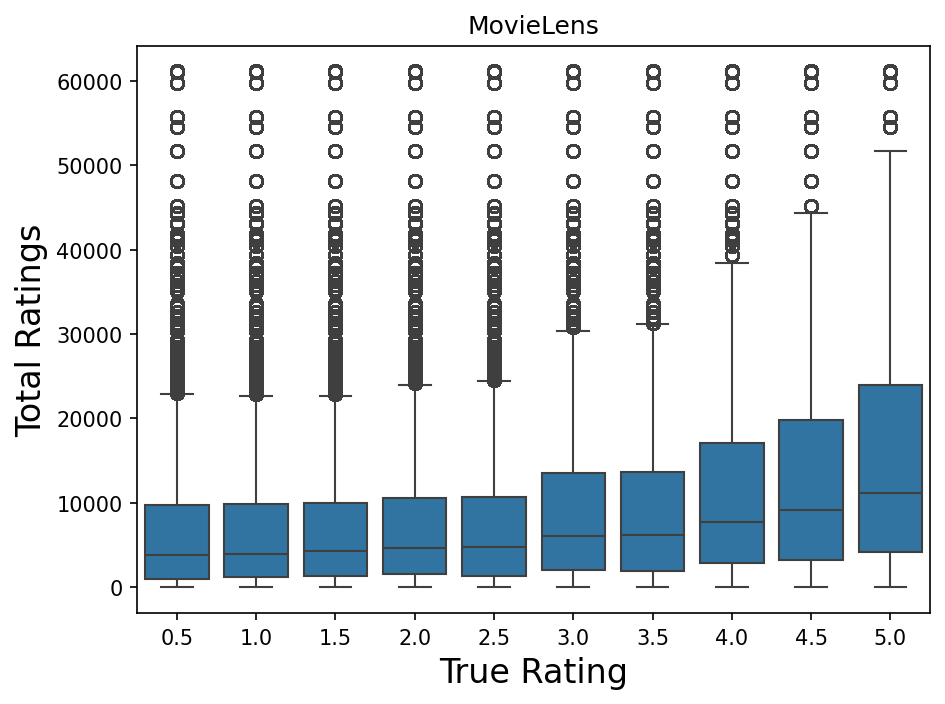

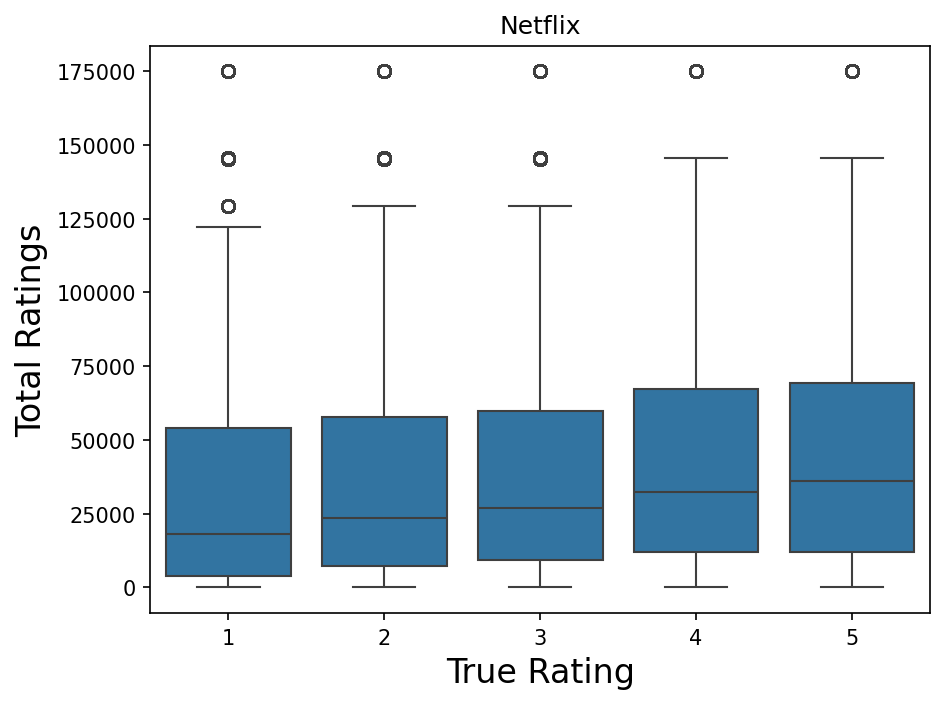

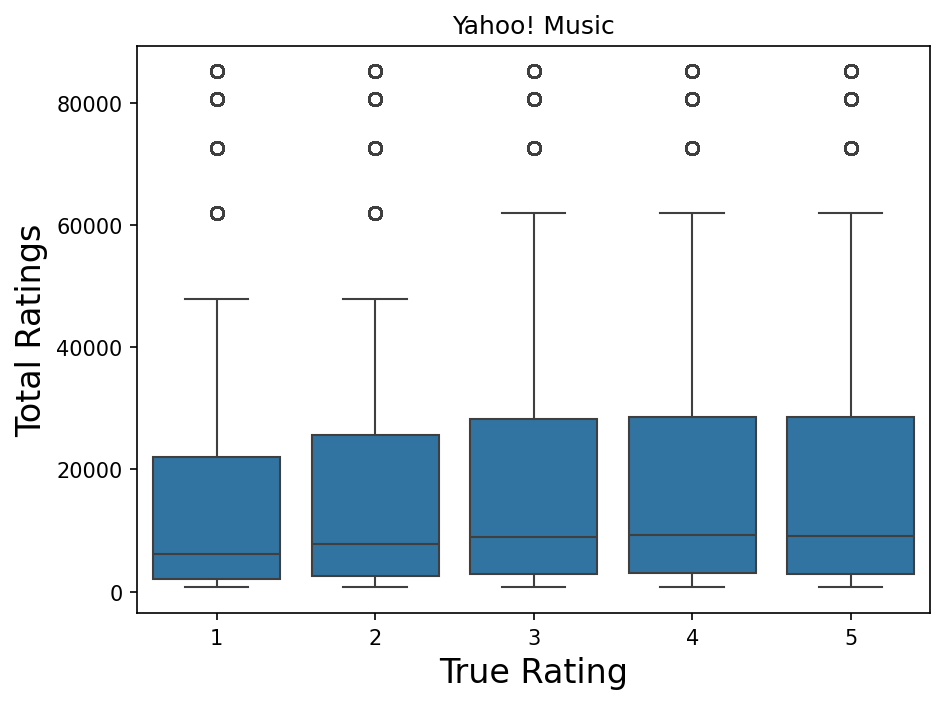

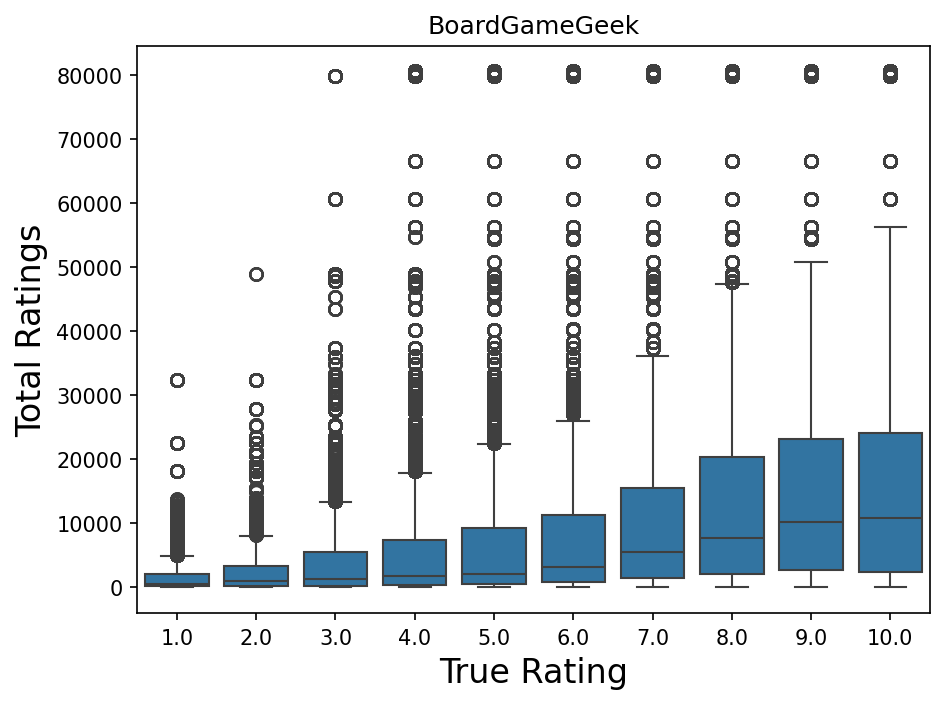

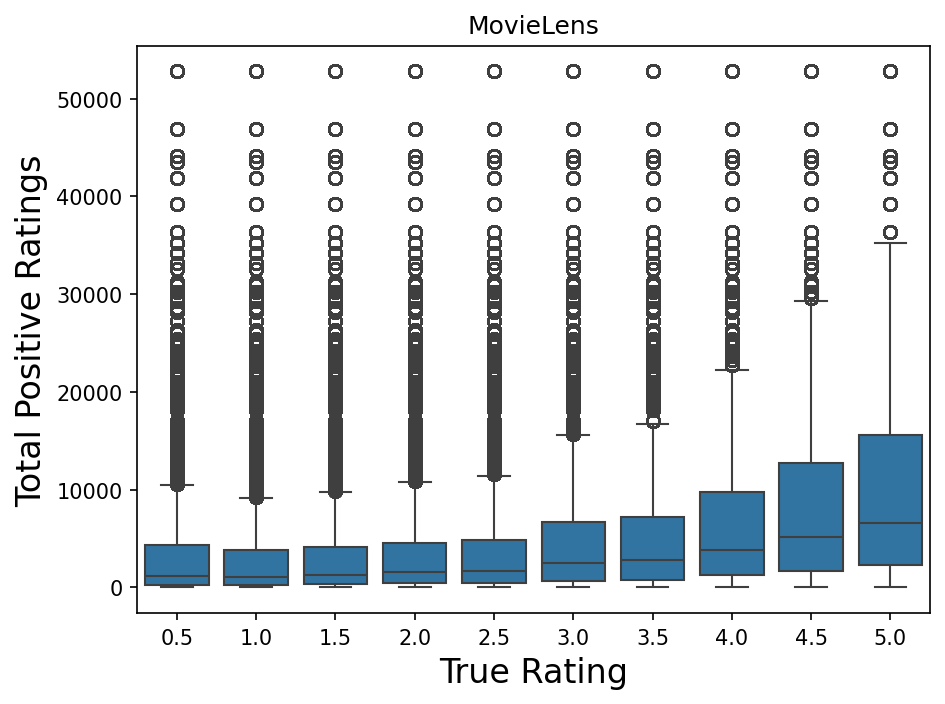

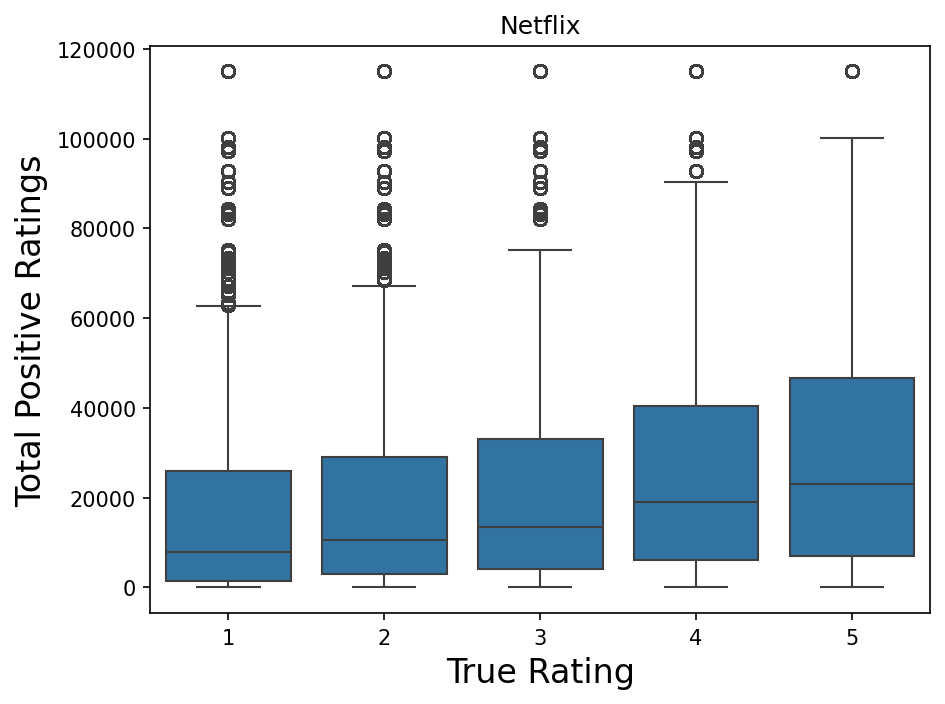

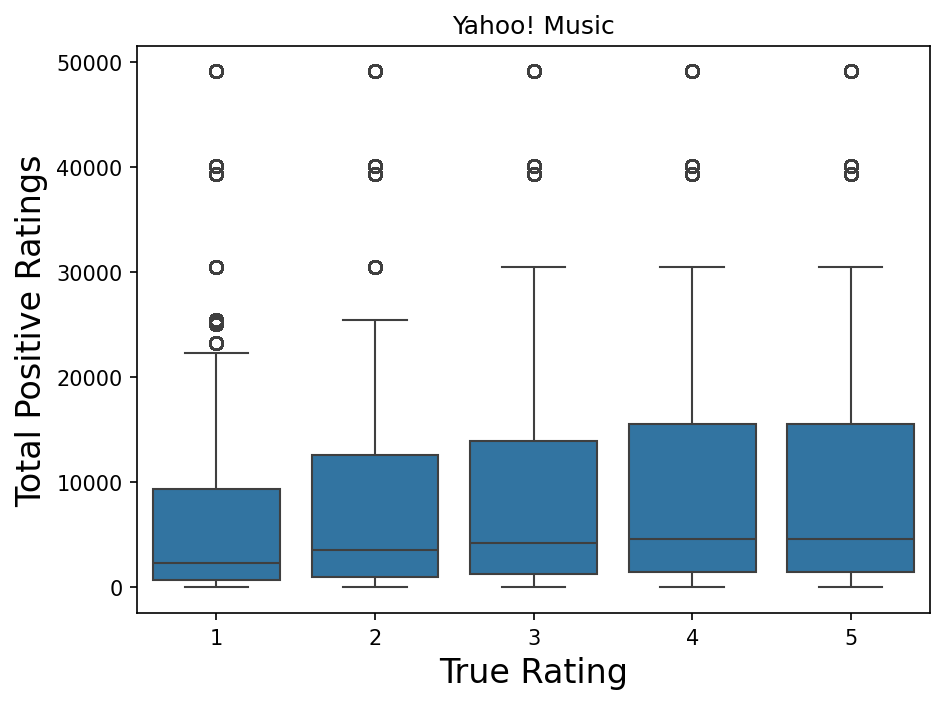

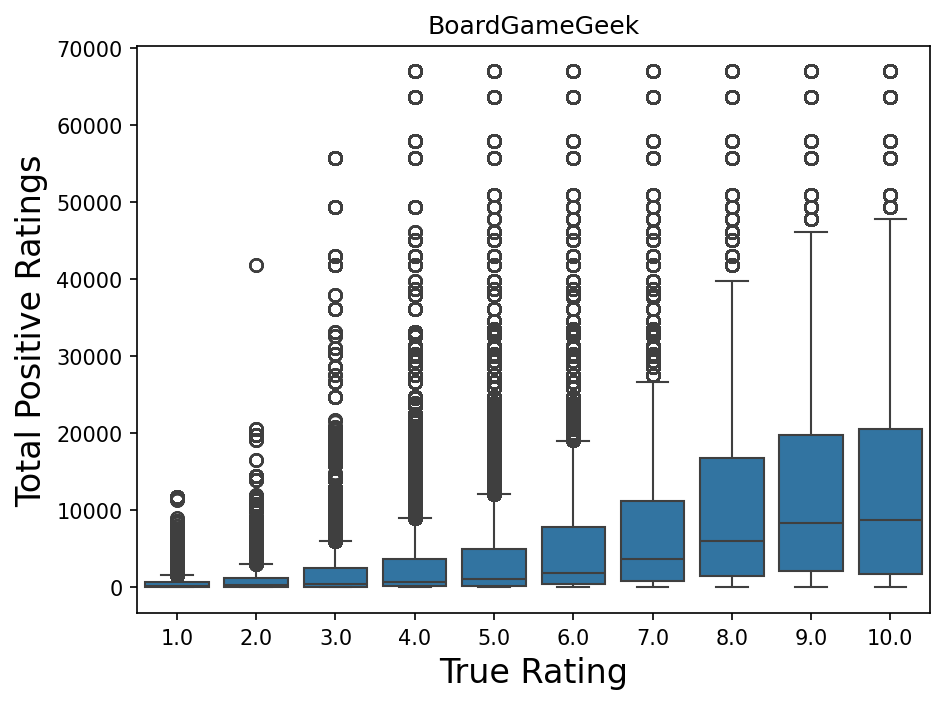

In [8]:
def PlotRatings(title, df, ratings, rating_bin, agg_column, description):
    pred = df.merge(ratings, on='item_id')
    plot = sns.boxplot(data=pred, x=rating_bin, y=agg_column)
    plot.set(title=title, xlabel='True Rating', ylabel=description)
    plt.show()

for agg_column, description in [
    ('avg_rating', 'Average Rating'),
    ('rating_count', 'Total Ratings'),
    ('positive_count', 'Total Positive Ratings')
]:
    PlotRatings('MovieLens', test_df1, ratings1, 'rating', agg_column, description)
    PlotRatings('Netflix', test_df2, ratings2, 'rating', agg_column, description)
    PlotRatings('Yahoo! Music', test_df3, ratings3, 'rating', agg_column, description)
    PlotRatings('BoardGameGeek', test_df4, ratings4, 'rating_bin', agg_column, description)
